# **MIT 6.5940 EfficientML.ai Fall 2023 Lab 4: LLM Quantization with AWQ**


## Introduction

This colab notebook provides code and a framework for Lab 4: LLM Quantization. You will learn how to quantize a large language model that can run efficiently. We will implement AWQ (activation aware weight only quantization) for 4 bit weight-only quantization.

Running large language models (LLMs) on the edge is of great importance, which not only enhances user experience but also addresses privacy concerns, as sensitive data remains localized and reduces the risk of potential breaches.

However, deploying LLMs on the edge presents significant challenges. Edge devices operate under tight power constraints, setting them apart from workstations or cloud servers. This translates to restricted memory bandwidth and limited peak computation throughput on the edge. For instance, the NVIDIA Jetson Orin Nano, with its 8GB DRAM, cannot accommodate even the most compact LLaMA-2 model in half precision. Thankfully, AWQ presents a push-the-button solution for weight quantization, empowering LLM inference on edge devices with constrained memory.

Furthermore, by using the AWQ 4-bit weight-only quantization algorithm, combined with an efficient 4-bit kernel, we can achieve the following acceleration on the RTX 4090. In the next lab section, we will also use TinyChatEnigne to achieve actual performance acceleration.

### Demo on an RTX 4090:


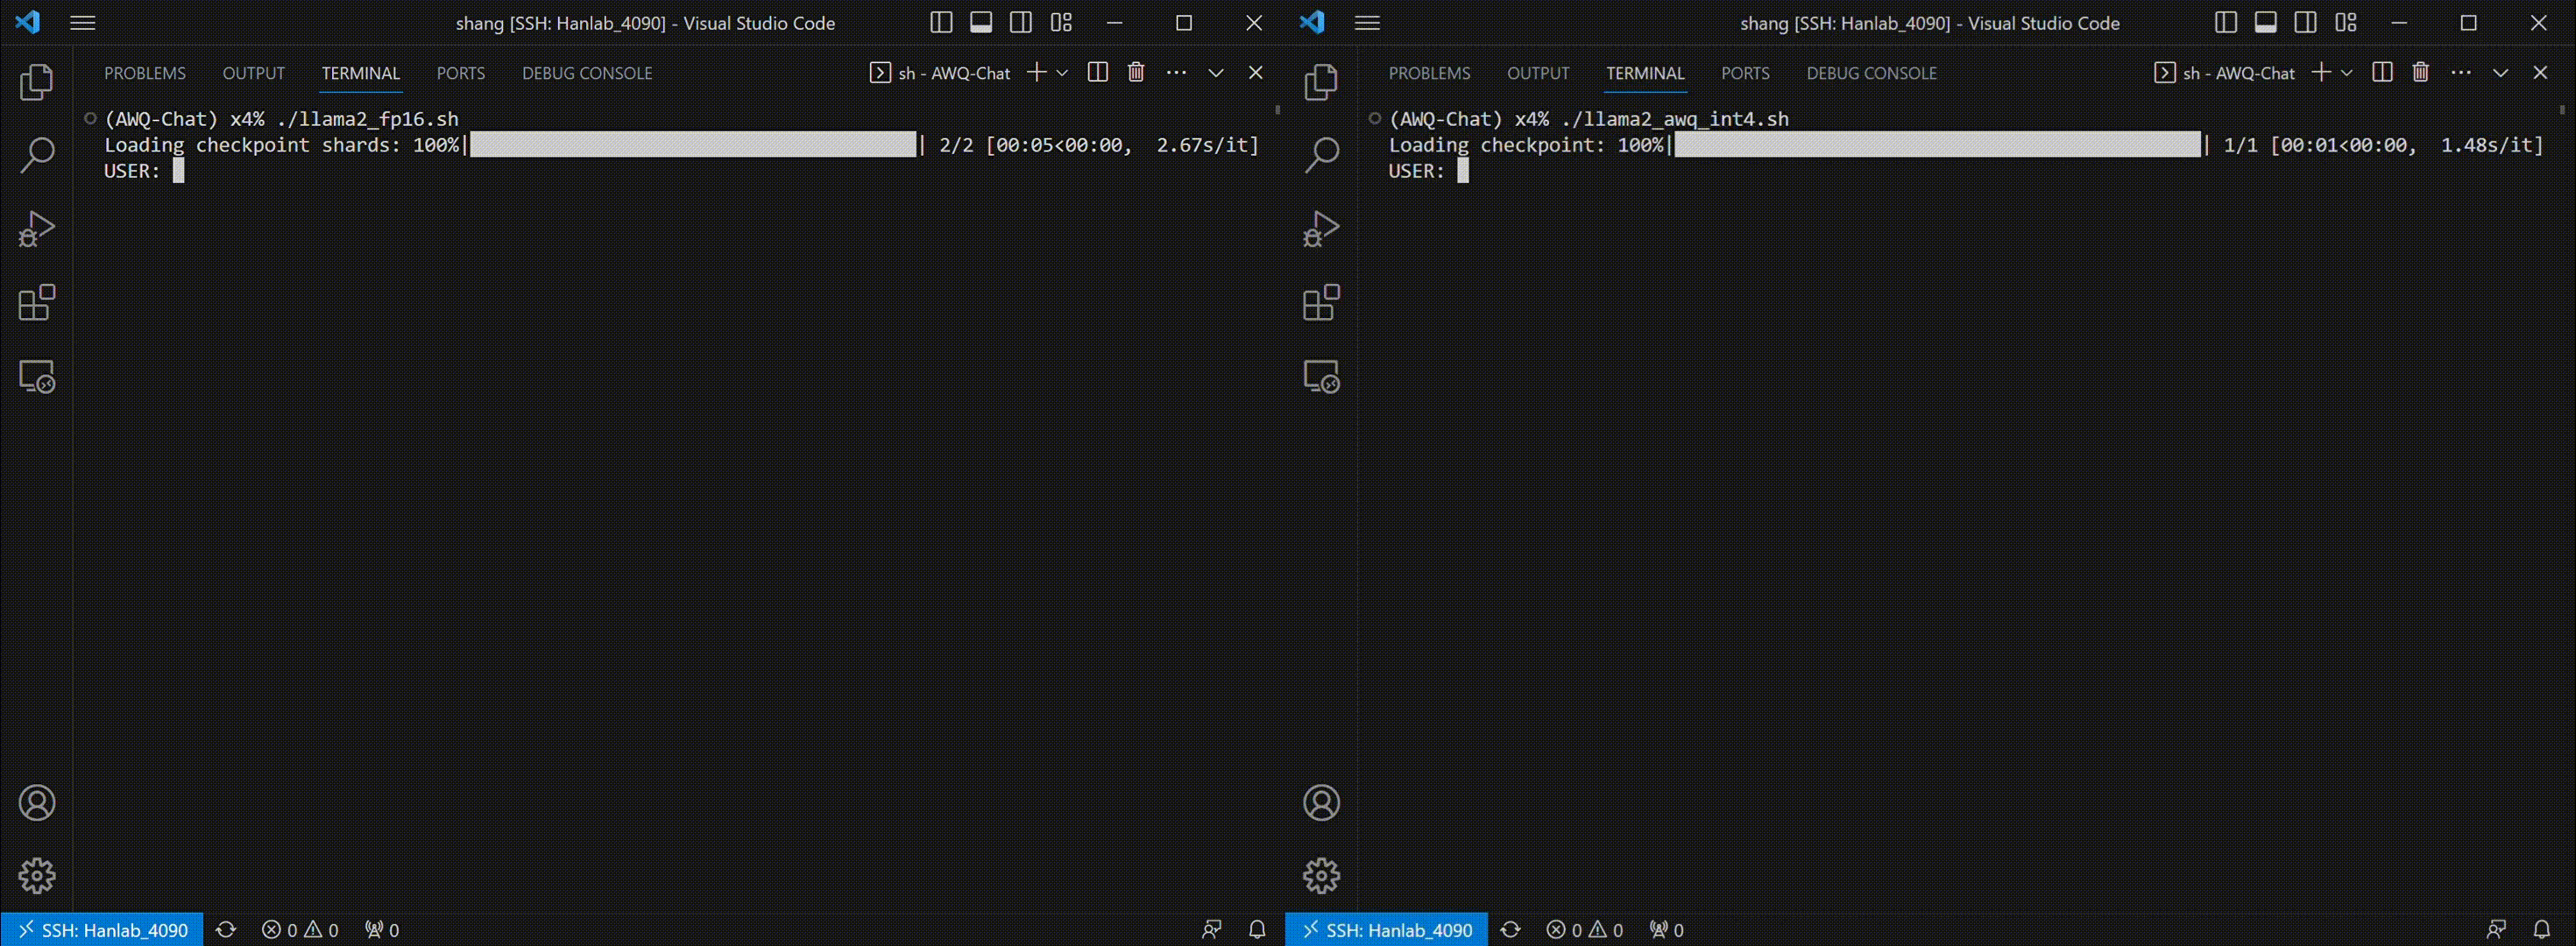

### Demo on an Apple MacBook Air (M1, 2020):


![demo.gif](https://github.com/mit-han-lab/TinyChatEngine/blob/main/assets/figures/chat_demo_m1.gif?raw=true)

# AWQ (activation aware weight only quantization)

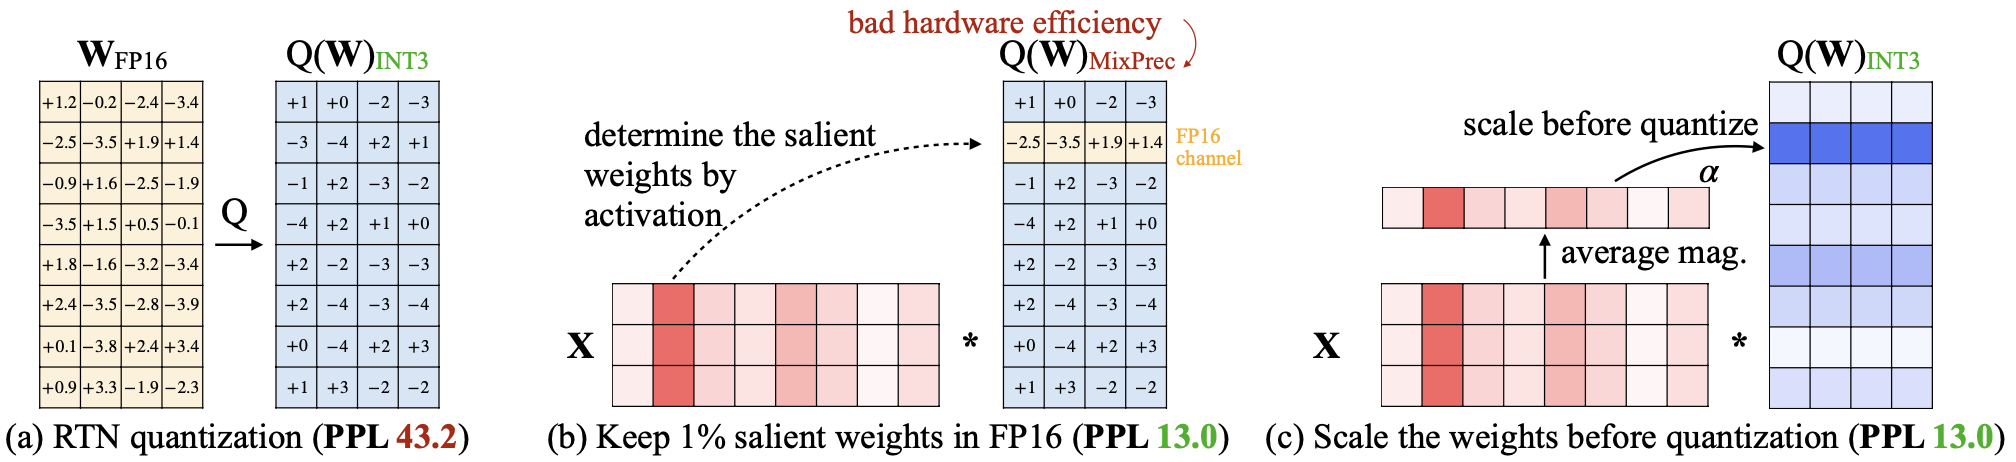

Large language models (LLMs) have shown excellent performance on various tasks, but the astronomical model size raises the hardware barrier for serving (memory size) and slows down token generation (memory bandwidth). LLM sizes and computation are increasing exponentially, while memory bandwidth is increasing slowly. This gap is a major bottleneck for LLMs. In this lab, we will explore the use of an novel quantization algorithm (AWQ) to reduce memory footprint of LLMs and achieve accelerations for inference.

In previous courses, we have learned the basic methods of quantization.
There are two types of quantization:

- Quantize both weight and activation
    - Better for computation-bounded scenarios: context stage, large batch inference
    - For example, SmoothQuant: W8A8 quantization
- Weight-only quantization
    - Better for memory-bounded scenarios: decoding stage, single batch inference
    - For example, AWQ that will be introduced in this lab: W4A16 quantization

For the LLaMA-65B model, in the decoding stage of single batch inference, we need to perform GEMV $[1, 8192] \times [8192, 8192]$. Taking the NVIDIA A100 80G as an example, its half-precision (FP16) performance is 312TFLOPS, and the memory bandwidth is about 2000GB/s. Therefore, its computation intensity is:

$$
\frac{\text{FLOP}}{\text{Byte}} = \frac{2\times 8192^2}{8192^2} << \frac{3.12\times 10^{11}}{2\times 10^9}
$$

This is very memory-bounded (~$10^2$ gap), which is why we need low-bit weight quantization.

## Setup

In [1]:
print('Installing packages...')
!pip install torch transformers==4.31.0 accelerate==0.21.0 sentencepiece==0.1.99 tokenizers==0.13.3  tqdm zstandard

Installing packages...


In [2]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [3]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc

Here we use wikitext-2 dataset for evaluation. The dataset is automatically downloaded by the code.

In [4]:
def evaluate(model, tokenizer):
    testenc = load_dataset(path='wikitext', name='wikitext-2-raw-v1', split='test')     
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):                  # 总共衡量 40 段 sequence 上模型的预测结果
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)        # 选取长度为 2048 的序列作为 batch
        with torch.no_grad():
            lm_logits = model(batch).logits     
            # 模型预测，lm_logits.size() = [batch_size, sequence_length, vocab_size]，batch_size 和 sequence_length 由输入决定，本案例中分别是 1 和 2048；vocab_size 由采用的 tokenizer 决定，本案例中是 50265
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        # 可以认为模型输出的结果是从每个 sequence 第二个 token 开始的预测值，这里要和 ground truth sequence 对齐，因此需要移位
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))    
        # 满足 Pytorch 中 CrossEntropyLoss 计算的要求，ground truth index 直接传递一维的 label，而无需 one-hot 编码
        # 详细解释：https://www.cnblogs.com/wj-1314/p/17260091.html
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))       # PPL 定义方法：exp(average_loss)


The following code is used to calculate the model size.

In [5]:
def get_model_size(model: nn.Module, data_width=16, group_size=-1):

    if group_size != -1:
        data_width += (16 + 4) / group_size

    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()

    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Let's first evaluate the perplexity and model size of the FP32 Model.

**加载 Hugging Face 模型的方法：**

由于网络原因，无法直接通过代码一键下载并加载模型，而需要通过国内镜像先下载模型后进行 load

具体方法参照：https://hf-mirror.com/ ，采用 huggingface-cli 离线下载

Jupyter notebook 中貌似无法直接读取 .bashrc 中定义的环境变量，因此需要再 terminal 中下载

通常只需要修改 model_path 为实际下载路径即可，但需要注意 datasets < 2.15.0 的版本加载本地模型会报错，需要更新：https://discuss.huggingface.co/t/valueerror-invalid-pattern-can-only-be-an-entire-path-component/80450

In [6]:
model_path = "opt-1.3b"
# model_path = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [7]:
# tokenizer 使用

# 加载序列
testenc = load_dataset(path='wikitext', name='wikitext-2-raw-v1', split='test')     
print(testenc['text'])
print(len(testenc['text']))

# 这里的 tokenizer 用于处理由 两个换行符连接 testenc['text'] 中文本内容组成的单个长字符串 
# return_tensors 指定返回为 pytorch 张量
# tokenizer 的输出为包含不同字段的字典，通常有 input_ids(转换后的张量)、token_type_ids(每个 token 的类型)、attention_mask(表示对哪些 token 进行 attention 计算)
testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')
print(testenc)
print(testenc['input_ids'].numel())

# 将关键的 index 加载进 GPU
testenc = testenc.input_ids.to(model.device)
print(testenc)
print(testenc.size())
# torch.Size([1, 287645])，
# index 的内容是二维张量，1 表示 batch size，287645 表示经过 tokenizer 之后得到的序列长度，其中的每个 index 和实际的文本序列相对应

vocab = tokenizer.get_vocab()       # vocab 存储了 index 和 实际文本 token 的对应字典
for index, token in enumerate(vocab):       # 由于需要通过文本 token 得到对应的 index，实际字典的 key 是 string，value 是整数 index
    print(f"Index: {index}, Token: {token}")
print(vocab["Robert"])              # 文字 token 对应的 index 

['', ' = Robert Boulter = \n', '', ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n', ' In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark Ravenhill . He

In [8]:
# Evaluate the model

# model_perplexity = evaluate(model, tokenizer)
# model_size = get_model_size(model, data_width=32, group_size=128)
# print(f"\nmodel perplexity: {model_perplexity:.2f}")
# print(f"model size: {model_size/MiB:.2f} MiB")

In [9]:
compressed_num = 0
uncompressed_num = 0
total_num = 0
for name, param in model.named_parameters():    # 递归获取当前模块的所有参数，所有参数只会出现一遍
    # print("Result of named_parameters:")
    # print(name)
    total_num += param.numel()
for n,m in model.named_modules():       
        # 递归地返回是模块名称和模块本身，既包含父模块，也包含叶子结点的子模块；需要注意这里的包含关系
    # print("Result of named_modules:")
    # print(n)                            
    # print(m)
    if isinstance(m,nn.Linear):
        # print(n)         
        # print(m)
        for n, param in m.named_parameters():    # 每个子 model 都有 parameter
            # print("name:", n)                    # 对于 Linear 而言，parameter 包含 weight 和 bias
            # print("param:", param, param.type)
            # print(param.data, param.data.type)   # param.data 获取对应的 tensor 内容
            # print(param.numel())
            pass

    if isinstance(m, nn.Linear):                # 如果需要统计某一 layer 的信息，需要细化到最内层，用 nn.Module 类型限定
        # print("Linear:", n)
        for param in m.parameters():
            compressed_num += param.data.numel()
    
    ## buggy
    # elif isinstance(m, nn.Module):
    #     print("Others:", n)         # 事实上，如果是递归定义模块，外层的模块名也会成为这里的 name，nn.Linear 和 这里的 else 并不能对应，统计是有重复的
    #     for param in m.parameters():
    #         uncompressed_num += param.data.numel()
print(compressed_num)
print(total_num)
print(compressed_num/total_num)
# 也可以发现，model 主要都是 Linear layer，在 99.5% 以上 
# 因此后文只需要对 Linear layer 的 weight 压缩即可

1311358976
1315758080
0.9966566011891791


Uniform quantization is to map real values in the range $[\beta, \alpha]$ to lie within $[0, 2^{b} - 1]$.

Notation:

- Quantized Weight: $w_q$

- Scale factor: $s_q$

- Zero Point: $z$
\begin{equation}
s_q = \frac{\alpha - \beta}{2^{b} - 1} \tag{1},
\end{equation}

\begin{equation}
z = -\text{Round}(\beta * scale) \tag{2},
\end{equation}

\begin{equation}
w_q = \text{Clamp}(\text{Round}(\frac{w}{s_q}) + z) \tag{3},
\end{equation}



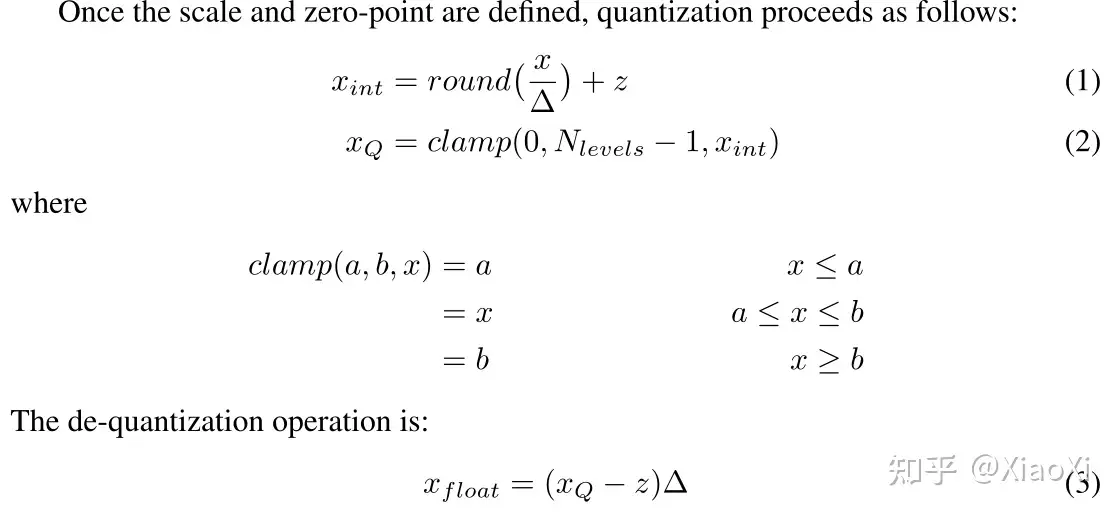

### pseudo quantization
The following code is for pseudo quantization.

Pseudo Quantization is used to simulate the effects of quantization on a model  without actually quantizing the model's weights. (i.e. rounding to the nearest quantized value and then **dequantizing back to a float**.)

采用的都是伪量化，不改变参与计算的数据类型方便和 Pytorch 兼容，只是采用 quantization 后再 dequantization，模拟量化带来的模型效果损失（主要原因是进行了 round）

In [10]:
# core quantization method (simulated quantization)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size=-1):
    org_w_shape = w.shape           # 原始权重形状
    if q_group_size > 0:            # 如果制定了量化组大小，则对应修改 tensor 形状
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    assert w.dim() == 2

    # Calculate the maximum (\alpha) and minimum values (\beta) in the tensor.
    max_val = w.amax(dim=1, keepdim=True)       
    # keepdim 使得即使求完 max 也不做维度压缩，沿着 dim = 1 求 amax 的结果是大小为 [w.size(0), 1] 的张量，相当于是在 quantization_group_size 大小的元素中找最大和最小，之后每个 quantization group 采用不同的 scale 和 zero
    # 这里实际采用的是 group quantization 的策略，细化了 quantization 的颗粒度，当然分组是随机的（通过 reshape 简单实现分组）
    assert max_val.dim() == 2 and max_val.size(0) == w.size(0) and max_val.size(1) == 1
    min_val = w.amin(dim=1, keepdim=True)
    assert min_val.dim() == 2 and min_val.size(0) == w.size(0) and min_val.size(1) == 1
    
    # 关于 Pytorch 中 dim 的使用：https://www.cnblogs.com/flix/p/11262606.html
    # 对于 tensor 的操作指定 dim 就是对指定 dim 包含的元素进行操作
    # 如二维张量 [[1,2],[3,4]]，dim 0 包含的对象是 [1,2]/[3,4] 这两个张量，进行的元素操作是张量间的运算；dim 1 包含的对象是 1/2，3/4 这两对标量，进行的元素操作是标量间的运算
    

    # Calculate the scale factor and zero point.  (Formula 1 & 2)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int      # 防止 scale 过小
    assert scales.shape == max_val.shape
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int) # 限制 zero 范围
    # 严格来说这里进行 clamp 默认 min_val 小于 0，这对 nn 的大部分 layer 都是成立的（数据分布符合正态分布）
    assert scales.shape == min_val.shape

    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # Quantize W: Map values in the range [\beta, \alpha] to lie within [0, 2^b - 1] (Formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int) 
    # 应用了广播机制，每个 q_group 共享 scale 和 zero，同时限制了 weight 范围
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    # Dequantize W (pseudo quantization, the inverse transformation of Formula 3)
    w = (w - zeros) * scales
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    assert torch.isnan(w).sum() == 0

    w = w.reshape(org_w_shape)
    return w

@torch.no_grad()
def pseudo_quantize_model_weight(
    model, w_bit, q_group_size,
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):        
            # 上面说明了，model 中 99% 以上都是 Linear layer，简单压缩 weight 矩阵即可
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

Let's evaluate the perplexity and model size of the quantized 3-bit Model.

In [11]:
# 清空 CUDA 缓存和 model 加载后占用的内存
# del model
# gc.collect()
# torch.cuda.empty_cache()

# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
# pseudo_quantize_model_weight(model, w_bit=3, q_group_size=128)      # 这个函数是直接修改 model 的 weight，实际使用时可能要传入副本

# Evaluate the model

# model_perplexity = evaluate(model, tokenizer)
# model_size = get_model_size(model, data_width=3, group_size=128)
# print(f"\nmodel perplexity: {model_perplexity:.2f}")
# print(f"model size: {model_size/MiB:.2f} MiB")

We can see that the model size has decreased, but the perplexity has significantly increased.

There is a observation in LLM activations that **outliers appear in a small fraction of the channels**. If one channel has an outlier, it **persistently appears in all tokens**. The variance amongst the channels for a given token is large (the activations in some channels are very large, but most are small), but the variance between the magnitudes of a given channel across tokens is small (outlier channels are consistently large).

According to the observation of AWQ, weight channels corresponding to activation outliers are more salient, and preserving those salient weights can lead to a significant performance improvement. Next, let's try to find the salient weights and retain them as original values to observe the change in perplexity.

The following code is used to load the calibration dataset, so as to obtain activation outliers to identify salient weights.

In [12]:
## 重新整理 calibration dataset, 组成大小为 block_size 的输入序列传递给模型
def get_calib_dataset(tokenizer=None, n_samples=256, block_size=512):
    dataset = load_dataset("mit-han-lab/pile-val-backup", split="validation")
    dataset = dataset.shuffle(seed=42)
    samples = []
    n_run = 0
    for data in dataset:
        line = data["text"]
        line = line.strip()
        line_encoded = tokenizer.encode(line)
        if len(line_encoded) > block_size:      
            continue
        sample = torch.tensor([line_encoded])
        if sample.numel() == 0:
            continue
        samples.append(sample)
        n_run += 1
        if n_run == n_samples:
            break

    # now concatenate all samples and split according to block size
    # 这里只是为了看 weight 和 activation 的分布，对预测的准确率没要求，因此可以直接 concatenate，不用关心语义是否连续
    cat_samples = torch.cat(samples, dim=1)
    n_split = cat_samples.shape[1] // block_size
    print(f" * Split into {n_split} blocks")
    return [cat_samples[:, i*block_size:(i+1)*block_size] for i in range(n_split)]

@torch.no_grad()
def get_calib_feat(model, tokenizer):
    input_dict = dict()
    def stat_input_max_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        x_max = x.view(-1, x.shape[-1]).abs().mean(dim=0).cpu().detach()       
        if name not in input_dict:
            input_dict[name] = [x_max]      # input_dict 的每个 key 代表 layer 名称，value 是 x_max 列表；x_max 列表大小是跑的总次数，每个元素是每次跑的输入
        else:
            input_dict[name] += [x_max]     # append list

    hooks = []
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):        # 研究对象是叶子节点 Linear layer
            hooks.append(
                m.register_forward_hook(            # m, x, y 会在 forward 过程中自动传递
                    partial(stat_input_max_hook, name=name)))       
                    # partial 偏函数用于固定函数的部分参数，生成的新函数调用时只需要传递剩余的参数

    print("Collecting activation scales...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    samples = get_calib_dataset(tokenizer)
    pbar = tqdm.tqdm(samples)
    for input_ids in pbar:
        input_ids = input_ids.to(device)
        model(input_ids)        # 运行 Model 后，input_dict 会在 forward 过程中自动被填充

    for hook in hooks:
        hook.remove()
        
    return input_dict

In [13]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
input_feat = get_calib_feat(model, tokenizer)

Repo card metadata block was not found. Setting CardData to empty.


 * Split into 127 blocks


100%|██████████| 127/127 [01:01<00:00,  2.05it/s]


In [14]:
# 下面我们希望观察所有 layer 中 activation 的分布, 这里已经是取 abs 并在 batch 间取 mean 的结果了

feature_map = []
for n, m in model.named_modules():
    if isinstance(m, nn.Linear):
        importance = sum(input_feat[n]).float()
        if len(importance) < 3000:          # 不考虑 project 到 8196 的 Linear layer，方便绘图
            feature_map.append(importance)
result = torch.stack(feature_map)
print(result.size())

torch.Size([121, 2048])


In [15]:
## 三维绘图 ##

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# feature_map = result[0:6,:]

# # 将张量转换为NumPy数组，以便使用matplotlib
# tensor_np = np.array(feature_map)

# # 创建一个新的图和子图
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # 绘制每个元素
# for i in range(tensor_np.shape[0]):
#     for j in range(tensor_np.shape[1]-1, -1, -1):
#         if(tensor_np[i,j]<1000):
#             ax.plot([j, j], [i, i], [0, tensor_np[i, j]], 'b-', alpha=0.4, linewidth = 0.4)
#         else:
#             ax.plot([j, j], [i, i], [0, tensor_np[i, j]], 'r-')

# # 设置坐标轴标签
# ax.set_xlabel('Input feature')
# ax.set_ylabel('Linear layers')
# ax.set_zlabel('Value')

# # 显示图形
# plt.show()


## 每个 layer 的二维绘图 ##

# import matplotlib.pyplot as plt

# # 假设我们有以下一维张量
# tensor = result[0]

# # 将张量的索引和值分别存储在两个列表中
# indices = list(range(len(tensor)))
# values = tensor

# # 创建一个新的图
# plt.figure()

# # 使用plot函数绘制图形
# plt.plot(indices, values, marker='o')  # marker='o' 表示在每个数据点上绘制一个圆圈标记

# # 设置坐标轴标签
# plt.xlabel('Input feature')
# plt.ylabel('Value')

# # 显示图形
# plt.show()

根据 result 可以发现，不同 Linear layer 的 input activation 某些特定的 feature 上的 value 都明显突出，这也是所要讨论的 outliers 

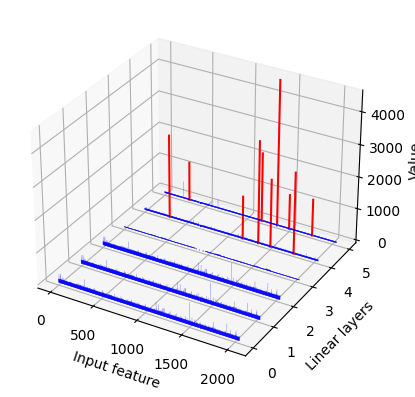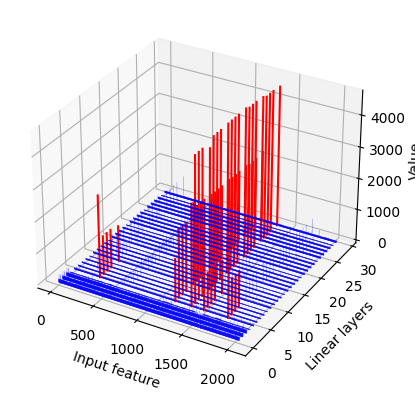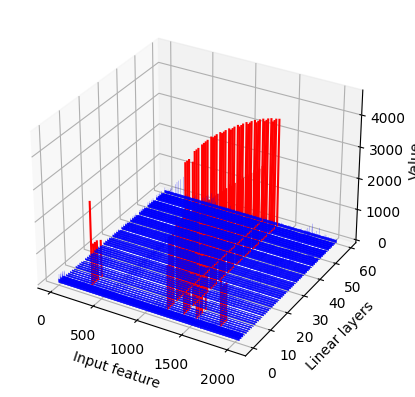

### Question 1 (50 pts)
#### Question 1.1 (20 pts)
Next, please add codes before and after the quantization to protect 1% of the salient weight channels (1% channels with highest importance), ensuring that their values remain unchanged after quantization. (**The desired perplexity is 17.15**)

In [16]:
@torch.no_grad()
def pseudo_quantize_model_salient_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels according to importance (hint: use torch.topk())
            # torch.topk() 返回对应两个值，一是包含 k 个最大值的元素的张量，二是这些元素的索引张量
            outlier_indices = torch.topk(importance, int(len(importance) * 0.01))[1]
            assert outlier_indices.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the salient weight channels
            outlier = m.weight.data[:, outlier_indices].clone()     # 注意 Linear layer 运算的实际操作涉及到 W^T：如果将 input 看成 [batch size, input feature] 大小的张量，则 W 是 [output feature, input feature] 大小的张量，完成的是 x*W^T；对于 W^T， 矩阵乘法中涉及到 x 中 outliers 的是行向量上的切片，反应到 W，应该在列向量上做相应位置的切片

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% salient weight channels to their original FP16 values
            m.weight.data[:, outlier_indices] = outlier

            ############### YOUR CODE ENDS HERE #################

In [17]:
# del model
# gc.collect()
# torch.cuda.empty_cache()
# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
# pseudo_quantize_model_salient_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
# model_perplexity = evaluate(model, tokenizer)
# model_size = get_model_size(model, data_width=3, group_size=128)
# print(f"\nmodel perplexity: {model_perplexity:.2f}")
# print(f"model size: {model_size/MiB:.2f} MiB")

#### Question 1.2 (15 pts)
Let's conduct an ablation experiment: randomly protect 1% of the weight channels, ensuring that their values remain unchanged after quantization, and then observe the perplexity. (**The desired perplexity is over 100**)




In [18]:
@torch.no_grad()
def pseudo_quantize_model_random_weight_fp16(
    model, w_bit, q_group_size, input_feat
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Randomly choose 1% of the weight channels
            outlier_mask = torch.randint(0, len(importance), (int(len(importance) * 0.01),))
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # Back up the values of the selected weight channels
            outlier = m.weight.data[:, outlier_mask].clone()

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Restore the 1% selected weight channels to their original FP16 values
            m.weight.data[:,outlier_mask] = outlier

            ############### YOUR CODE ENDS HERE #################

In [19]:
# del model
# gc.collect()
# torch.cuda.empty_cache()
# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
# pseudo_quantize_model_random_weight_fp16(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
# model_perplexity = evaluate(model, tokenizer)
# model_size = get_model_size(model, data_width=3, group_size=128)
# print(f"\nmodel perplexity: {model_perplexity:.2f}")
# print(f"model size: {model_size/MiB:.2f} MiB")

#### Question 1.3 (15 pts)
Please provide a possible explanation for why the salient weight channels are so important.

#### Answser 1.3
Salient weight channels are important because they play a critical role in the performance and robustness of large language models. Their influence on model outputs, sensitivity to quantization errors, and contribution to model robustness make them key targets for careful handling during the quantization process. Methods like AWQ recognize the importance of these channels and aim to preserve their precision to ensure that the quantized model remains effective and reliable.

### Question 2 (50 pts)

Despite keeping 0.1% of weights in FP16 can improve the quantized performance
without a noticeable increase in model size (measured in total bits), such a mixed-precision data type will make the system implementation difficult. We need to come up with a method to protect the important weights without actually keeping them as FP16.

According to the methodology of AWQ, simply scaling up the salient weight channels can protect them. The principle is as follows:

- Consider a linear layer channel $\mathbf{y} = \mathbf{w}x$ (from $\mathbf{W}x$). We care about the quantization error from $Q(\mathbf{w})x$.

- $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$, $Δ = \frac{\max(|w|)}{2^{N - 1}}$.
- The scaled version is $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$.
- The $RoundErr$ is always ~0.25 (average from 0-0.5).
- When the group size is relatively large (e.g., 128), scaling up one channel usually does not increase the maximum value in a group (i.e. $Δ$ remains unchanged).
- Thus, $Err(Q(\mathbf{w} \cdot s)(\frac{x}{s})) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x\cdot \mathbf{\frac{1}{s}}$ < $Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x = Err(Q(\mathbf{w}) x)$.

Taking the following figure as an example, if we assume 3-bit int quantization, then the quantization error caused by the value in the last column of the second row of $W(+1.4)$ should be $Err(Q(\mathbf{w}) x) = Δ\cdot RoundErr(\frac{\mathbf{w}}{Δ})\cdot x$ = $\frac{4}{2^{3 - 1}} * |1.4 - 1.0| * (2 + 2 + 2) = 2.4$.

If the second channel is scaled up by a factor of $2$, the resulting quantization error would reduce to $\frac{4}{2^{3 - 1}} * |2.8 - 3.0| * (2/2 + 2/2 + 2/2) = 0.6$.

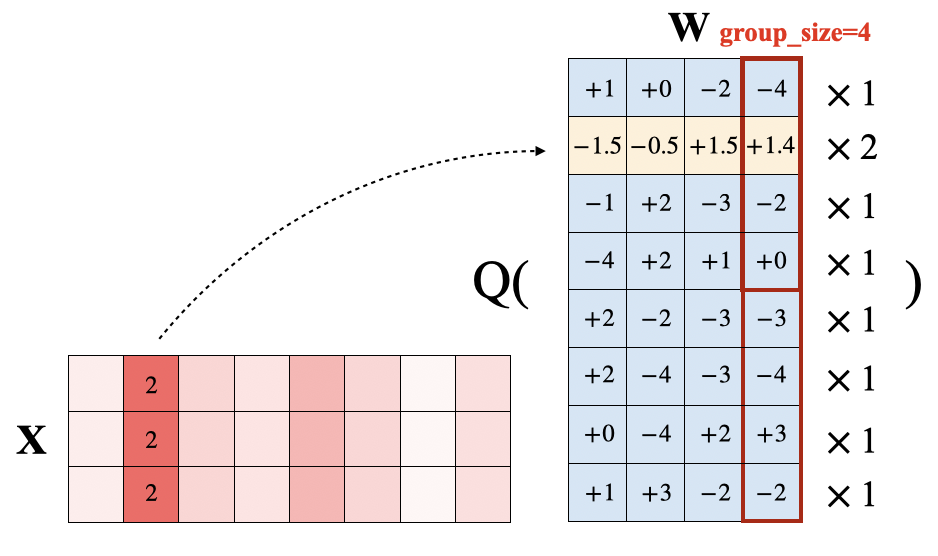

#### Question 2.1 (20 pts)
Please write code to scale up the salient weight channels, then quantize it, and finally scale it back down, and observe the changes in perplexity. (**The desired perplexity is 18.93**)

In [20]:
@torch.no_grad()
def pseudo_quantize_model_weight_scaleup(
    model, w_bit, q_group_size, input_feat, scale_factor
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance = sum(input_feat[n]).float()

            ############### YOUR CODE STARTS HERE ###############

            # Step 1: Find 1% of the salient weight channels
            outlier_mask = torch.topk(importance, int(len(importance)*0.01))[1]
            assert outlier_mask.dim() == 1

            ############### YOUR CODE ENDS HERE #################

            # To simulate applying the scale factor, we can simply multiply it before quantization, and then divide by the scale factor after quantization.
            # Scale up the values of the salient weight channels
            m.weight.data[:, outlier_mask] *= scale_factor

            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Scale back down the values of the salient weight channels
            m.weight.data[:, outlier_mask] /= scale_factor

            ############### YOUR CODE ENDS HERE #################

In [21]:
# del model
# gc.collect()
# torch.cuda.empty_cache()
# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
# pseudo_quantize_model_weight_scaleup(model, w_bit=3, q_group_size=128, input_feat=input_feat, scale_factor=8)

# Evaluate the model
# model_perplexity = evaluate(model, tokenizer)
# model_size = get_model_size(model, data_width=3, group_size=128)
# print(f"\nmodel perplexity: {model_perplexity:.2f}")
# print(f"model size: {model_size/MiB:.2f} MiB")

#### Question 2.2 (15 pts)
Please try different scale factors (e.g. 1, 2, 3, and 4) in the code and observe the changes in perplexity.

Did you observe the perplexity first decreasing and then increasing? Please explain why this would happen based on the principle mentioned above.

#### Answer 2.2
**Observations:**

scale factor:1, PPL: 121.9

scale factor:2, PPL: 18.93

scale factor:3, PPL: 19.25

scale factor:4, PPL: 21.26

scale factor:8, PPL: 100.99

**Explanations:**

Scaling up at a large factor may increase the maximum value in the group (i.e. Δ will increase). It will affect other channel's quantization.

注意到实际量化时采用的是顺序分组的 group quantization，salient channel 中的元素可能和其他 channel 混在一起，拉高了整体 group 的 max_value，影响其他 channel 的量化

### Question 2.3 (15 pts)
Due to the instability of fine-tuning, it would be a better choice to find the optimal $s$ within a predefined search space. We can find the optimal scale in the search space to protect the salient weights while also considering other values. In practice, it can be observed that considering just the activations is sufficient to yield good results. Please add the code for search and run it to observe the perplexity. (**The desired perplexity is 17.92**)

$$
𝐋(\mathbf{s})=\lVert Q(\mathbf{W}\cdot \mathbf{s})  (\mathbf{s^{-1}} \cdot \mathbf{X}) - \mathbf{W}\mathbf{X}  \rVert,  \quad\mathbf{s}= \mathbf{s_X}^{\alpha}
$$
$$
\mathbf{s}^* = \text{argmin}_{\mathbf{s}} 𝐋(\mathbf{s}),\quad \alpha^*=\text{argmin}_{\alpha} 𝐋(\mathbf{s_X}^{\alpha})
$$

In [22]:
@torch.no_grad()
def scale_ln_fcs(ln, fcs, scales):      # 无需额外计算，fcs 的 scale up 在之后的 layer norm 中 scale down
    if not isinstance(fcs, list):
        fcs = [fcs]

    scales = scales.to(ln.weight.device)

    ln.weight.div_(scales)
    if hasattr(ln, 'bias') and ln.bias is not None:
        ln.bias.div_(scales)

    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))      # 同之前的讨论，由于 W 需要经过转置，这里是每个列都有不同的 scale factor

    # 在缩放后检查所有参数是否出现 NaN，防止数值不稳定问题
    for p in ln.parameters():
        assert torch.isnan(p).sum() == 0
    for fc in fcs:
        for p in fc.parameters():
            assert torch.isnan(p).sum() == 0


@torch.no_grad()
def scale_fc_fc(fc1, fc2, scales):      
    # 两个 fc layer 相邻，则 fc2 scale up 要求 fc2 input scale down；而 fc2 input 是 fc1 output，因此可以通过 fc1 scale down 实现 fc1 output(fc2 input) scale down 
    assert isinstance(fc1, nn.Linear)
    assert isinstance(fc2, nn.Linear)

    scales = scales.to(fc1.weight.device)

    # fc1.weight.div_(scales.view(-1, 1))
    fc1.weight[-scales.size(0):].div_(scales.view(-1, 1))
    if fc1.bias is not None:
        fc1.bias.div_(scales.view(-1))

    fc2.weight.mul_(scales.view(1, -1))

    for p in fc1.parameters():
        assert torch.isnan(p).sum() == 0
    for p in fc2.parameters():
        assert torch.isnan(p).sum() == 0

@torch.no_grad()
def auto_scale_block(module, name, w_bit,
                     q_group_size,
                     input_feat):

    # find the best scale ratio
    def _search_module_scale(block, linears2scale: list, x, kwargs={}):

        x = x.to(next(block.parameters()).device)       # 移动到和 module parameter 相同的计算设备上
        with torch.no_grad():
            org_out = block(x, **kwargs)                # 计算原始结果
            if isinstance(org_out, tuple):
                org_out = org_out[0]

        s_x = x.view(-1, x.shape[-1]).abs().mean(0)     # 在 batch 上取了均值

        ############### YOUR CODE STARTS HERE ###############

        # Step 1: Initialize the best_error, best_ratio and best_scales
        best_error = torch.inf
        best_ratio = -1
        best_scales = 0

        ############### YOUR CODE ENDS HERE #################

        n_grid = 20
        history = []

        org_sd = {k: v.cpu() for k, v in block.state_dict().items()}        # 提前存储模型的参数，之后每轮搜索后都要重加载最初的参数
        for ratio in range(n_grid):
            # ratio is the \alpha in the formula
            ratio = ratio * 1 / n_grid                      # 暴力搜索，ratio 从 0 - 19/20

            ############### YOUR CODE STARTS HERE ###############

            # Step 2: Calculate the scales by the formula: scales = s_x^ratio
            scales = torch.clamp(s_x, 1e-5) ** ratio        # 相当于这里的 scale 是有 input 决定的，input 越大，scale 也越大；相比于之前找 1% 的 channel 并随机给一个 scaling factor，这里是对所有 channel 都设置 scaling factor，且 scaling factor 有公式化的计算范式
            assert scales.shape == s_x.shape

            ############### YOUR CODE ENDS HERE #################

            scales = scales / (scales.max() * scales.min()).sqrt().view(1, -1)      # 极差归一化

            for fc in linears2scale:   # linears2scale 应该是直接和 input 计算的 weight，传入的 model(block) 的主要组成部分也应该是这些 Linear layers

                scales = scales.to(fc.weight.device)

                # Scale up the values of the weight channels
                fc.weight.mul_(scales)              # 这里的 scale 已经反应了 input 信息

                fc.weight.data = pseudo_quantize_tensor(fc.weight.data, w_bit, q_group_size)

                ############### YOUR CODE STARTS HERE ###############

                # Step 3: Scale back down the values of the weight channels
                fc.weight.data /= scales

                ############### YOUR CODE ENDS HERE #################

            out = block(x, **kwargs)        # 量化后的结果
            if isinstance(out, tuple):
                out = out[0]

            loss = (org_out - out).float().pow(2).mean().item()  # float prevents overflow
            history.append(loss)
            is_best = loss < best_error
            if is_best:                         # 最优化的结果是对每个 block 都有最小的量化前后的计算结果的误差
                best_error = loss
                best_ratio = ratio
                best_scales = scales
            block.load_state_dict(org_sd)       # 恢复原始 model

        if best_ratio == -1:
            print(history)
            raise Exception

        best_scales = best_scales.view(-1)

        assert torch.isnan(best_scales).sum() == 0, best_scales
        return best_scales.detach()             # 经过 20 次尝试，得到合适的 scaling factor 列表


    # 对于主要的 Linear layers, 模型的计算顺序是: 
    # self_attn layer norm -> self_attn block(qkv) -> self_attn_out_proj -> final layer norm -> fc1 -> fc2
    # 这里的 scale factor 的转移过程需要满足模型的计算顺序

    # attention input
    inp = input_feat[name + '.self_attn.out_proj']            # 使用 out_proj 作为输入得到的 PPL 17.93
    # inp = input_feat[name + '.self_attn.q_proj']            # 按理说应该使用 q_proj 作为输入，这样的 PPL 是 18.32，反而提升了？
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0).unsqueeze(0)      # 为什么要增加维度？
    # 效果是将 inp 中所有元素沿着 y 轴堆叠：list([1,2,3],[4,5,6]) -> tensor([[[1,2,3],[4,5,6]]])，满足 self_attn 的 input 要求
    qkv = [module.self_attn.q_proj, module.self_attn.k_proj, module.self_attn.v_proj]
    final_scales = _search_module_scale(module.self_attn, qkv, inp)         
    # 对于 self_attn 这样的 block，qkv 是需要 quantized 的 Linear layer，inp 是对应的输入
    scale_ln_fcs(module.self_attn_layer_norm, qkv, final_scales)

    # attn out
    inp = input_feat[name + '.self_attn.out_proj']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.self_attn.out_proj, [module.self_attn.out_proj], inp)
    scale_fc_fc(module.self_attn.v_proj, module.self_attn.out_proj, final_scales)

    # fc1
    inp = input_feat[name + '.fc1']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc1, [module.fc1], inp)
    scale_ln_fcs(module.final_layer_norm, module.fc1, final_scales)

    # fc2
    inp = input_feat[name + '.fc2']
    inp = torch.cat([x.unsqueeze(0) for x in inp], dim=0)
    final_scales = _search_module_scale(module.fc2, [module.fc2], inp)
    scale_fc_fc(module.fc1, module.fc2, final_scales)

@torch.no_grad()
def pseudo_quantize_model_weight_auto_scale(
    model, w_bit, q_group_size, input_feat
):
    from transformers.models.opt.modeling_opt import OPTDecoderLayer

    for name, module in model.named_modules():
        if isinstance(module, OPTDecoderLayer):
            auto_scale_block(module, name, w_bit, q_group_size, input_feat)         # 计算并转移 scaling factor

    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size=q_group_size)       # 进行真正的伪量化

In [23]:
del model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model_weight_auto_scale(model, w_bit=3, q_group_size=128, input_feat=input_feat)

# Evaluate the model
model_perplexity = evaluate(model, tokenizer)
model_size = get_model_size(model, data_width=3, group_size=128)
print(f"\nmodel perplexity: {model_perplexity:.2f}")
print(f"model size: {model_size/MiB:.2f} MiB")

evaluating...: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it]



model perplexity: 17.93
model size: 495.06 MiB


## Bonus point
Any optimization techniques without mixed precision on your mind? Try to implement them to improve the perplexity further! If you can further improve the perplexity to $x$, you can get $\max(0, (17.92 - x) \times 10)$ bonus points here!


In conclusion, we can significantly reduce perplexity without using mixed-precision. Through an efficient kernel implementation, the 4-bit model can achieve decent acceleration for inference. Through learning about TinyChatEngine in the next section, we can run a LLaMA-7B model on our own laptops like the demo presented in the introduction.

In [24]:
## 转换成 onnx 格式，使用 netron 进行可视化

# del model
# gc.collect()
# torch.cuda.empty_cache()
# model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

# testenc = load_dataset(path='wikitext', name='wikitext-2-raw-v1', split='test')     
# testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')
# testenc = testenc.input_ids.to(model.device)
# model = model.eval()
# batch = testenc[:, (0 * 2048):((0 + 1) * 2048)].to(model.device)        # 选取长度为 2048 的序列作为 batch
# with torch.no_grad():
#     lm_logits = model(batch).logits     


# torch.onnx.export(model, batch, 'Pytorch2onnx/opt-1.3b.onnx', input_names=["features"], output_names=["logits"], opset_version=11)

In [25]:
for n,x in input_feat.items():
    print(n)
    print(x)

model.decoder.layers.0.self_attn.q_proj
[tensor([0.6426, 1.1104, 0.6763,  ..., 0.8788, 0.7848, 0.9072]), tensor([0.8398, 0.9753, 0.6587,  ..., 0.9474, 0.8963, 1.0139]), tensor([0.6953, 0.9467, 0.7077,  ..., 0.9880, 0.8717, 1.1071]), tensor([0.7411, 1.0068, 0.6889,  ..., 0.8941, 0.8445, 1.0309]), tensor([0.7134, 1.0023, 0.6646,  ..., 0.8477, 0.8400, 0.9472]), tensor([0.7798, 1.0331, 0.6903,  ..., 0.8612, 0.8653, 0.8959]), tensor([0.6724, 1.0668, 0.6740,  ..., 0.9068, 0.7778, 0.9272]), tensor([0.6942, 1.0035, 0.6847,  ..., 0.9113, 0.8141, 0.9453]), tensor([0.7413, 1.0519, 0.6666,  ..., 0.8829, 0.8350, 0.9524]), tensor([0.6732, 1.0323, 0.7342,  ..., 0.8694, 0.8196, 0.9554]), tensor([0.6470, 1.0428, 0.6626,  ..., 0.8959, 0.8298, 0.9391]), tensor([0.6512, 1.0515, 0.6628,  ..., 0.9213, 0.8213, 0.9727]), tensor([0.7192, 1.0989, 0.6861,  ..., 0.8611, 0.8263, 0.9447]), tensor([0.6950, 1.0221, 0.6406,  ..., 0.8509, 0.8280, 0.9256]), tensor([0.6587, 1.0741, 0.6570,  ..., 0.8923, 0.7629, 0.9199]),

In [26]:
print(model)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 2048, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 2048)
      (final_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0): OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
          (final_layer_norm): LayerNorm((204

In [28]:
from transformers.models.opt.modeling_opt import OPTDecoderLayer
for k,v in model.state_dict().items():
   print("k:", k)
   print("v:", v)

k: model.decoder.embed_tokens.weight
v: tensor([[ 0.0203, -0.0407, -0.0203,  ..., -0.0469, -0.0235,  0.0000],
        [ 0.0195, -0.0390, -0.0195,  ..., -0.0468, -0.0234,  0.0000],
        [-0.0411,  0.0617,  0.0617,  ..., -0.0238, -0.0238, -0.0238],
        ...,
        [ 0.0195, -0.0389, -0.0195,  ..., -0.0469, -0.0235,  0.0235],
        [ 0.0208, -0.0416, -0.0208,  ..., -0.0470, -0.0235,  0.0000],
        [ 0.0206, -0.0412, -0.0206,  ..., -0.0468, -0.0234, -0.0234]],
       device='cuda:0')
k: model.decoder.embed_positions.weight
v: tensor([[-6.0654e-03, -5.9700e-04,  6.3324e-04,  ..., -6.5613e-03,
          6.4325e-04,  6.5327e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-8.1406e-03, -2.6221e-01,  6.0768e-03,  ...,  1.7273e-02,
         -5.0621e-03, -1.6220e-02],
        ...,
        [ 1.2657e-02, -1.1238e-02,  1.3676e-03,  ..., -1.0376e-02,
          2.5225e-04,  1.6983e-02],
        [ 1.4015e-02, -2.0538e-02,